# [Training] Semantic Segmentation with Transformers

## Model

This notebook is built for the [SegFormer model](https://huggingface.co/docs/transformers/model_doc/segformer#transformers.SegformerForSemanticSegmentation) and is supposed to run on any semantic segmentation dataset.

## Data augmentation

This notebook leverages `torchvision`'s [`transforms` module](https://pytorch.org/vision/stable/transforms.html) for applying data augmentation. Using other augmentation libraries like `albumentations` is also [supported](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb).

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/nvidia/mit-b0 checkpoint, but note that there are others [available on the hub](https://huggingface.co/models?pipeline_tag=image-segmentation).

In [1]:
model_checkpoint = "nvidia/mit-b0"  # pre-trained model from which to fine-tune
batch_size = 4  # batch size for training and evaluation

Before we start, let's install the `datasets`, `transformers`, and `evaluate` libraries. We also install Git-LFS to upload the model checkpoints to Hub.



In [2]:
!pip -q install datasets transformers evaluate
!pip install torch

!git lfs install
!git config --global credential.helper store

Updated Git hooks.
Git LFS initialized.


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries or run the `pip install` command above with the `--upgrade` flag.

You can share the resulting model with the community. By pushing the model to the Hub, others can discover your model and build on top of it. You also get an automatically generated model card that documents how the model works and a widget that will allow anyone to try out the model directly in the browser. To enable this, you'll need to login to your account.

In [3]:
! pip install -U ipywidgets==7.7.1
from huggingface_hub import notebook_login

notebook_login()

## Fine-tuning a model on a semantic segmentation task

### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download our custom dataset into a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict).

We're using the Sidewalk dataset which is dataset of sidewalk images gathered in Belgium in the summer of 2021. You can learn more about the dataset [here](https://huggingface.co/datasets/segments/sidewalk-semantic).

In [4]:
from datasets import load_dataset
hf_dataset_identifier = "eborghi10/VineyardRows"
ds = load_dataset(hf_dataset_identifier)

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training. 

IoU (short for Intersection over Union) tells us the amount of overlap between two sets. In our case, these sets will be the ground-truth segmentation map and the predicted segmentation map. To learn more, you can check out [this article](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/).

In [5]:
import evaluate

metric = evaluate.load("mean_iou")

The `ds` object itself is a `DatasetDict`, which contains one key per split (in this case, only "train" for a training split).

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 452
    })
    validation: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 48
    })
})

Here, the `features` tell us what each example is consisted of:

* `pixel_values`: the actual image
* `label`: segmentation mask



To access an actual element, you need to select a split first, then give an index:

Found existing installation: pillow 11.1.0
Uninstalling pillow-11.1.0:
  Successfully uninstalled pillow-11.1.0
  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.5 MB)


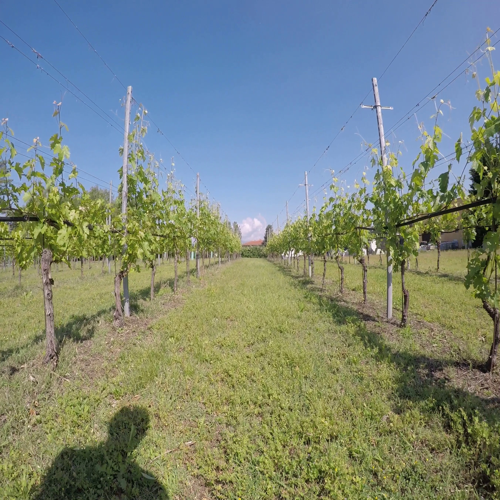

In [7]:
!pip uninstall -y pillow
!pip install -U pillow image

# from torchvision.transforms.functional import to_pil_image

example = ds["train"][10]
example["pixel_values"].resize((500, 500))

Each of the pixels above can be associated to a particular category. Let's load all the categories that are associated with the dataset. Let's also create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [8]:
from huggingface_hub import hf_hub_download
import json

filename = "id2label.json"
id2label = json.load(open(
    hf_hub_download(hf_dataset_identifier, filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

In [9]:
num_labels, list(label2id.keys())

(2, ['unlabeled', 'vineyard-row'])

**Note**: This dataset specificaly sets the 0th index as being `unlabeled`. We want to take this information into consideration while computing the loss. Specifically, we'll want to mask the pixels where the network predicted `unlabeled` and avoid computing the loss for it since it doesn't contribute to to training that much.

Let's shuffle the dataset and split the dataset in a train and test set. We'll explicitly define a random seed to use when calling `ds.shuffle()` to ensure our results are the same each time we run this cell.

In [10]:
ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]
len(train_ds), len(test_ds)

(361, 91)

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called a feature extractor with the `AutoFeatureExtractor.from_pretrained` method.

This feature extractor is a minimal preprocessor that can be used to prepare images for model training and inference.

In [11]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint)
feature_extractor

/home/emiliano/semantic-transformer/lib/python3.12/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/emiliano/semantic-transformer/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


SegformerFeatureExtractor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

In [12]:
from torchvision.transforms import ColorJitter
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

We also defined some data augmentations to make our model more resilient to different lighting conditions. We used the [`ColorJitter`](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html) function from `torchvision` to randomly change the brightness, contrast, saturation, and hue of the images in the batch. 

Also, notice the differences in between transformations applied to the train and test splits. We're only applying jittering to the training split and not to the test split. Data augmentation is usually a training-only step and isn't applied during evaluation. 

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. We will use the `SegformerForSemanticSegmentation` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom segmentation head is created (with a custom number of output neurons).

In [13]:
from transformers import SegformerForSemanticSegmentation

model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (the weights and bias of the `decode_head` layer) and randomly initializing some other (the weights and bias of a new `decode_head` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To fine-tune the model, we'll use Hugging Face's [Trainer API](https://huggingface.co/docs/transformers/main_classes/trainer). To use the `Trainer`, we'll need to define the training configuration and any evaluation metrics we might want to use.

First, we'll set up the [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). This defines all training hyperparameters, such as learning rate and the number of epochs, frequency to save the model and so on. We also specify to push the model to the hub after training (`push_to_hub=True`) and specify a model name (`hub_model_id`).

In [14]:
!pip install transformers[torch]
!pip install "accelerate>=0.26.0"

from transformers import TrainingArguments

epochs = 5#0
lr = 0.00006
batch_size = 4

hub_model_id = "segformer-vineyard-rows"

training_args = TrainingArguments(
    f"{hub_model_id}-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
)

Next, we'll define a function that computes the evaluation metric we want to work with. Because we're doing semantic segmentation, we'll use the [mean Intersection over Union (mIoU)](https://huggingface.co/spaces/evaluate-metric/mean_iou), which is directly accessible in the [`evaluate` library](https://huggingface.co/docs/evaluate/index). IoU represents the overlap of segmentation masks. Mean IoU is the average of the IoU of all semantic classes. Take a look at [this blogpost](https://www.jeremyjordan.me/evaluating-image-segmentation-models/) for an overview of evaluation metrics for image segmentation.

Because our model outputs logits with dimensions height/4 and width/4, we have to upscale them before we can compute the mIoU.

In [15]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics


Finally, we can instantiate a `Trainer` object.



In [16]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    processing_class=feature_extractor,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

Notice that we're passing `feature_extractor` to the `Trainer`. This will ensure the feature extractor is also uploaded to the Hub along with the model checkpoints.

Now that our trainer is set up, training is as simple as calling the train function. We don't need to worry about managing our GPU(s), the trainer will take care of that.

In [20]:
from transformers import SegformerImageProcessor, SegformerForImageClassification

image = ds["train"][10]["pixel_values"]

image_processor = SegformerImageProcessor.from_pretrained(model_checkpoint)
model = SegformerForImageClassification.from_pretrained(model_checkpoint)

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-1.741159439086914, 1.472244143486023] which cannot be converted to uint8.

In [17]:
trainer.train()

RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

When we're done with training, we can push our fine-tuned model to the Hub.

This will also automatically create a model card with our results. We'll supply some extra information in kwargs to make the model card more complete.

In [ ]:
kwargs = {
    "tags": ["vision", "image-segmentation", "vineyard"],
    "finetuned_from": model_checkpoint,
    "dataset": "VineyardRows",
}

trainer.push_to_hub(**kwargs)